# 04. Linking Reddit and BBC GoodFood

In [1]:
import requests               
import pandas as pd          
from scrapy import Selector  
from tqdm import tqdm
import spacy
import sys

# Import our own modules
sys.path.append("../scripts/")
import chadtools

In [50]:
bbclink = 'https://www.bbcgoodfood.com/search?q='
response = requests.get(bbclink)
sel = Selector(text=response.text)
links = []

recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
links.extend(recipecards)  
prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

In [51]:
base_url = 'https://www.bbcgoodfood.com/search?q=&limit=1000&page='

links = []
for i in tqdm(range(1, 11)):
    response = requests.get(base_url + str(i))
    sel = Selector(text = response.text)
    recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
    links.extend(recipecards)  

prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

len(final_links)

100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


10011

### Create a DataFrame containing the nutritional data of all the recipes on BBCGoodFood 

In [106]:
session = requests.Session()

def get_nutrition(url):
    response2 = session.get(url)
    sel2 = Selector(text=response2.text)
    table = sel2.css('table.key-value-blocks.hidden-print.mt-xxs')
    bbc = {}
    bbc['bbcgf_title'] = sel2.css('h1.heading-1 ::text').get()
    bbc['calories'] = table.css('td.key-value-blocks__value ::text').get()
    bbc['salt'] = table.xpath('.//*[contains(text(), "salt")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['fat'] = table.xpath('.//*[contains(text(), "fat")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['sugars'] = table.xpath('.//*[contains(text(), "sugars")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['saturates'] = table.xpath('.//*[contains(text(), "saturates")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['carbs'] = table.xpath('.//*[contains(text(), "carbs")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['protein'] = table.xpath('.//*[contains(text(), "protein")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['fibre'] = table.xpath('.//*[contains(text(), "fibre")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['bbcgf_ratings_raw'] = sel2.css("div.rating__values span.sr-only ::text").get()
    return bbc

bbc = [get_nutrition(url) for url in tqdm(final_links)]

df_bbc = pd.DataFrame(bbc)
df_bbc['bbcgf_ratings'] = df_bbc['bbcgf_ratings_raw'].str.extract(r'(\d+\.\d+)').astype(float) / 5.0 
df_bbc.head(10)

100%|██████████| 10011/10011 [2:31:43<00:00,  1.10it/s] 


,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings_raw,bbcgf_ratings
0,Chicken & chorizo jambalaya,445,1.2,10,7,3,64,30,2,A star rating of 4.8 out of 5.,0.96
1,Lemon drizzle cake,399,0.3,21,33,13,50,5,1,A star rating of 4.7 out of 5.,0.94
2,Chilli con carne recipe,387,2.32,17,1,6,25,36,6,A star rating of 4.8 out of 5.,0.96
3,Best ever chocolate brownies recipe,150,0.1,9,12,5,15,2,1,A star rating of 4.8 out of 5.,0.96
4,Creamy courgette lasagne,405,1.36,21,13,8,38,18,4,A star rating of 4.6 out of 5.,0.92
5,Classic Victoria sandwich recipe,558,0.9,28,57,17,76,5,0.6,A star rating of 4.5 out of 5.,0.90
6,Classic Christmas cake,678,0.6,29,79,12,88,9,3,A star rating of 4.7 out of 5.,0.94
7,Chicken noodle soup,217,2.5,2,1,0.4,26,26,0.6,A star rating of 4.8 out of 5.,0.96
8,Easy chocolate fudge cake,608,0.7,33,52,11,69,7,2,A star rating of 4.7 out of 5.,0.94
9,Sweet potato & peanut curry,387,0.6,25,15,18,32,6,7,A star rating of 4.7 out of 5.,0.94


### Save the data as a CSV file 

In [107]:
df_bbc.to_csv('../data/bbc_data.csv', index=False)

### Read cleaned_posts.json and bbc_data.csv

In [2]:
df_filtered = pd.read_json('../data/cleaned_posts.json', orient='records')
df_filtered.tail()

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,comment_link,permalink
995,jhi1cz,Vegetarian Pumpkin Meatballs with a Heart of C...,57,6,\n\nHere another recipe with pumpkin!! A deli...,1603581735000,0.899902,Fruit\Vegetarian,italian_cook,https://www.reddit.com/gallery/jhi1cz,https://oauth.reddit.com/r/recipes/comments/jh...,https://reddit.com/r/recipes/comments/jhi1cz/v...
996,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,7,6,Recipe.....\n\n[Short Video](https://youtu.be/...,1602879492000,0.649902,Fruit\Vegetarian,PassionateHobbies,https://i.redd.it/bpootodgbit51.jpg,https://oauth.reddit.com/r/recipes/comments/jc...,https://reddit.com/r/recipes/comments/jcgb7j/b...
997,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,22,5,Ingredients:\n\n* 7 Tablespoons olive oil\n* ...,1600970345000,0.830078,Fruit\Vegetarian,BrinaElka,https://i.redd.it/l7osuhkcm4p51.jpg,https://oauth.reddit.com/r/recipes/comments/iz...,https://reddit.com/r/recipes/comments/iz12pg/o...
998,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,2694,41,**Recipe here originally:** [**Easy Mushroom B...,1600565227000,0.979980,Fruit\Vegetarian,BushyEyes,https://i.redd.it/511qxuct57o51.jpg,https://oauth.reddit.com/r/recipes/comments/iw...,https://reddit.com/r/recipes/comments/iw3wli/m...
999,isunwt,Easy Tomato Risotto with Parmesan,1800,35,**Recipe here originally:** [**Easy Tomato Ris...,1600122747000,0.990234,Fruit\Vegetarian,BushyEyes,https://i.redd.it/0qb76yy3m6n51.jpg,https://oauth.reddit.com/r/recipes/comments/is...,https://reddit.com/r/recipes/comments/isunwt/e...


In [3]:
df_bbc = pd.read_csv('../data/bbc_data.csv')
df_bbc.head()

,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings_raw,bbcgf_ratings
0,Chicken & chorizo jambalaya,445.0,1.20,10.0,7.0,3.0,64.0,30.0,2.0,A star rating of 4.8 out of 5.,0.96
1,Lemon drizzle cake,399.0,0.30,21.0,33.0,13.0,50.0,5.0,1.0,A star rating of 4.7 out of 5.,0.94
2,Chilli con carne recipe,387.0,2.32,17.0,1.0,6.0,25.0,36.0,6.0,A star rating of 4.8 out of 5.,0.96
3,Best ever chocolate brownies recipe,150.0,0.10,9.0,12.0,5.0,15.0,2.0,1.0,A star rating of 4.8 out of 5.,0.96
4,Creamy courgette lasagne,405.0,1.36,21.0,13.0,8.0,38.0,18.0,4.0,A star rating of 4.6 out of 5.,0.92


In [4]:
len(df_filtered)

1000

## Calculating cosine similarity and merging columns based on the maximum similarity 

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

df_reddit = df_filtered.copy()
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
similarity_threshold = 0.75
merge_columns = ['bbcgf_title', 'calories', 'salt', 'fat', 'sugars', 'saturates', 'carbs', 'protein', 'fibre', 'bbcgf_ratings']

# Encode titles using Sentence Transformer
embeddings_reddit = model.encode(df_reddit['title'].tolist())
embeddings_bbc = model.encode(df_bbc['bbcgf_title'].tolist())

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_reddit, embeddings_bbc)

# Find the indices and values of the maximum similarity in each row
max_similarity_indices = cosine_sim_matrix.argmax(axis=1)
max_similarity_values = cosine_sim_matrix.max(axis=1)

# Mask indices where the similarity is below the threshold
mask = max_similarity_values > similarity_threshold

# Merge columns based on the max similarity
df_reddit.loc[mask, merge_columns] = df_bbc.iloc[max_similarity_indices[mask]][merge_columns].values

df_reddit.tail()

/var/folders/m1/v5zskq_n3473s_qmdwjwwd7w0000gn/T/ipykernel_74891/4270176532.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Buffalo chicken', 'Prawn katsu burgers', 'Cinnamon rolls', 'Mushroom risotto', 'Turmeric tea', 'Duck breasts with redcurrant & onion relish', 'Sugar cookies', 'Chicken & chorizo paella', 'Chilli & fennel frosted nuts', 'Leftover turkey & noodle soup', 'Nasi goreng (Indonesian stir-fried rice)', 'Homemade apple pie', 'Chicken, leek & brown rice stir-fry', 'Warm Thai chicken & noodle salad', 'Butternut squash and red pepper soup', 'Lemony prawn pasta', 'Creamy tomato soup', 'Stout-braised short ribs with horseradish & carrots', 'Lemon-spiced chicken with chickpeas', 'Beef & beer pie', 'Ramen with chicken bone broth, pork shoulder, soft-boiled egg & greens', 'Chicken soup', 'Oxtail stew', 'Chicken and vegetable soup', 'Butter biscuits', 'Veggie stir-fried noodles', 'Chicken with rice & pea

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
995,jhi1cz,Vegetarian Pumpkin Meatballs with a Heart of C...,57,6,\n\nHere another recipe with pumpkin!! A deli...,1603581735000,0.899902,Fruit\Vegetarian,italian_cook,https://www.reddit.com/gallery/jhi1cz,...,Veggie meatballs with tomato courgetti,258.0,0.70,11.0,12.0,1.0,24.0,12.0,9.0,NaN
996,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,7,6,Recipe.....\n\n[Short Video](https://youtu.be/...,1602879492000,0.649902,Fruit\Vegetarian,PassionateHobbies,https://i.redd.it/bpootodgbit51.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,22,5,Ingredients:\n\n* 7 Tablespoons olive oil\n* ...,1600970345000,0.830078,Fruit\Vegetarian,BrinaElka,https://i.redd.it/l7osuhkcm4p51.jpg,...,Baked tomato & mozzarella orzo,546.0,0.99,18.0,9.0,9.0,67.0,26.0,5.0,0.84
998,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,2694,41,**Recipe here originally:** [**Easy Mushroom B...,1600565227000,0.979980,Fruit\Vegetarian,BushyEyes,https://i.redd.it/511qxuct57o51.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,isunwt,Easy Tomato Risotto with Parmesan,1800,35,**Recipe here originally:** [**Easy Tomato Ris...,1600122747000,0.990234,Fruit\Vegetarian,BushyEyes,https://i.redd.it/0qb76yy3m6n51.jpg,...,Easy baked tomato risotto,411.0,1.30,NaN,3.0,6.0,65.0,14.0,3.0,0.90


In [6]:
df_reddit.to_csv('../data/merged_data.csv', index=False)

for easy ref for now, can delete later 

In [116]:
selected_columns = ['title', 'upvote_ratio', 'bbcgf_title', 'calories', 'salt', 'fat', 'sugars', 'saturates', 'carbs', 'protein', 'fibre', 'bbcgf_ratings']
df_selected = df_reddit[selected_columns]
df_selected.tail(15)

,title,upvote_ratio,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
985,Beetroot risotto with creamy goat cheese,0.979980,Beetroot risotto with feta,727.0,1.90,24.0,19.0,9.0,93.0,22.0,8.0,0.96
986,Tunisian inspired chickpeas,0.939941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,Simple Spanakopita (spinach pie),0.979980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,Black Bean Veggie Dip,0.970215,Avocado & cannellini bean dip,194.0,0.30,14.0,1.0,2.0,10.0,5.0,5.0,0.90
989,Chilli Non-Carne With Roasted Peppers,0.970215,Smoky chilli con carne,395.0,1.00,23.0,7.0,8.0,17.0,27.0,7.0,0.96
990,"Green shakshuka with spinach, parsley, articho...",0.990234,Green shakshuka with harissa & crispy shallots,410.0,1.20,27.0,11.0,8.0,16.0,23.0,8.0,0.96
991,Sweet and tangy pineapple and cucumber pickle,0.979980,Pickled pineapple & sriracha grilled cheese,1118.0,4.40,75.0,23.0,29.0,74.0,3.0,5.0,0.96
992,Apple-Cheddar Grilled Cheese Sandwiches with T...,0.919922,Cider & onion soup with cheese & apple toasts,523.0,2.30,31.0,16.0,19.0,40.0,14.0,6.0,0.94
993,Easy Miso Fried Rice!,0.979980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,Onigirazu with Okra &amp; Smoked Tofu,0.990234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Produce a dataframe for analysis by dropping rows with no nutrition data 

In [8]:
df_for_analysis = df_reddit.dropna(subset=merge_columns, how='all')
df_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  555 non-null    object 
 1   title               555 non-null    object 
 2   score               555 non-null    int64  
 3   num_comments        555 non-null    int64  
 4   ingredient_comment  555 non-null    object 
 5   created_utc         555 non-null    int64  
 6   upvote_ratio        555 non-null    float64
 7   link_flair_text     555 non-null    object 
 8   author              555 non-null    object 
 9   url                 555 non-null    object 
 10  comment_link        555 non-null    object 
 11  permalink           555 non-null    object 
 12  bbcgf_title         555 non-null    object 
 13  calories            553 non-null    float64
 14  salt                553 non-null    float64
 15  fat                 552 non-null    float64
 16  sugars       

In [10]:
df_for_analysis.head()

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
0,19d0wfc,Buffalo Chicken Tenders,202,12,**Recipe here originally:** [**Buffalo Chicken...,1705944195000,0.959961,Recipe,BushyEyes,https://i.redd.it/qtwisr8gz0ec1.jpeg,...,Buffalo chicken,520.0,7.40,35.0,11.0,15.0,11.0,39.0,3.0,0.88
1,1998zka,Prawn Katsu Baos,272,11,This one is high impact and a showstopper for ...,1705528588000,0.950195,Recipe,TheLuckiestDragon,https://i.redd.it/q81uyef4o2dc1.jpeg,...,Prawn katsu burgers,1070.0,2.80,74.0,13.0,12.0,68.0,30.0,6.0,0.90
2,18zcqmd,Cinnamon Rolls,256,21,"# Homemade Cinnamon Rolls\n\nFor full recipe, ...",1704476711000,0.959961,Recipe,pangibear,https://i.redd.it/7uef78dbsnac1.jpeg,...,Cinnamon rolls,415.0,0.90,18.0,24.0,11.0,55.0,8.0,2.0,0.84
3,18vf164,Mushroom-Taleggio Risotto,184,6,**Recipe here originally:** [**Mushroom-Talegg...,1704050722000,0.979980,Recipe,BushyEyes,https://i.redd.it/qc5akriilo9c1.jpeg,...,Mushroom risotto,445.0,1.45,17.0,3.0,7.7,63.0,15.0,4.0,0.94
5,18tse01,Turmeric Chicken Soup,138,9,**Recipe here originally:** [**Turmeric Chicke...,1703870926000,0.939941,Recipe,BushyEyes,https://i.redd.it/ssrzjdpzq99c1.jpeg,...,Turmeric tea,10.0,0.01,0.5,0.1,0.2,1.0,0.5,0.3,0.96


In [11]:
len(df_for_analysis)

555

In [12]:
df_for_analysis.to_csv('../data/merged_data_for_analysis.csv', index=False)

## Analysis of merged Reddit and BBC Good Food data

In [13]:
df_for_analysis = pd.read_csv('../data/merged_data_for_analysis.csv')

In [14]:
df_desserts = df_for_analysis[df_for_analysis['link_flair_text']=='Dessert']
df_recipe = df_for_analysis[df_for_analysis['link_flair_text']=='Recipe']
df_pasta = df_for_analysis[df_for_analysis['link_flair_text']=='Pasta']
df_poultry = df_for_analysis[df_for_analysis['link_flair_text']=='Poultry']
df_drink = df_for_analysis[df_for_analysis['link_flair_text']=='Drink']
df_beef = df_for_analysis[df_for_analysis['link_flair_text']=='Beef']
df_pork = df_for_analysis[df_for_analysis['link_flair_text']=='Pork']
df_seafood = df_for_analysis[df_for_analysis['link_flair_text']=='Seafood']
df_fruitveg = df_for_analysis[df_for_analysis['link_flair_text']=='Fruit\Vegetarian']

In [33]:
# plot a histogram of the bbc ratings for each flair 
from plotnine import ggplot, aes, geom_histogram, ggtitle, element_text, themes
flair_names = ['Dessert', 'Recipe', 'Pasta', 'Poultry', 'Drink', 'Beef', 'Pork', 'Seafood', 'Fruit\Vegetarian']

for flair in flair_names:
    plot = (
        ggplot(df_for_analysis[df_for_analysis["link_flair_text"] == flair], aes(x='upvote_ratio')) + 
        geom_histogram(binwidth=0.01, fill='#5c3da4') +
        themes.theme_matplotlib() +
        ggtitle(f"Frequency of {flair} posts by bbc good food ratings ratio") +
        themes.theme(plot_title = element_text(weight='bold', color="black")) +
        themes.theme(aspect_ratio=9/16)
    )

    plot.save(f"../plots/{flair}_hist.png", dpi=300) 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Dessert_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Recipe_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Pasta_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Poultry_hist.png
/Users/

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 84 rows containing missing values.


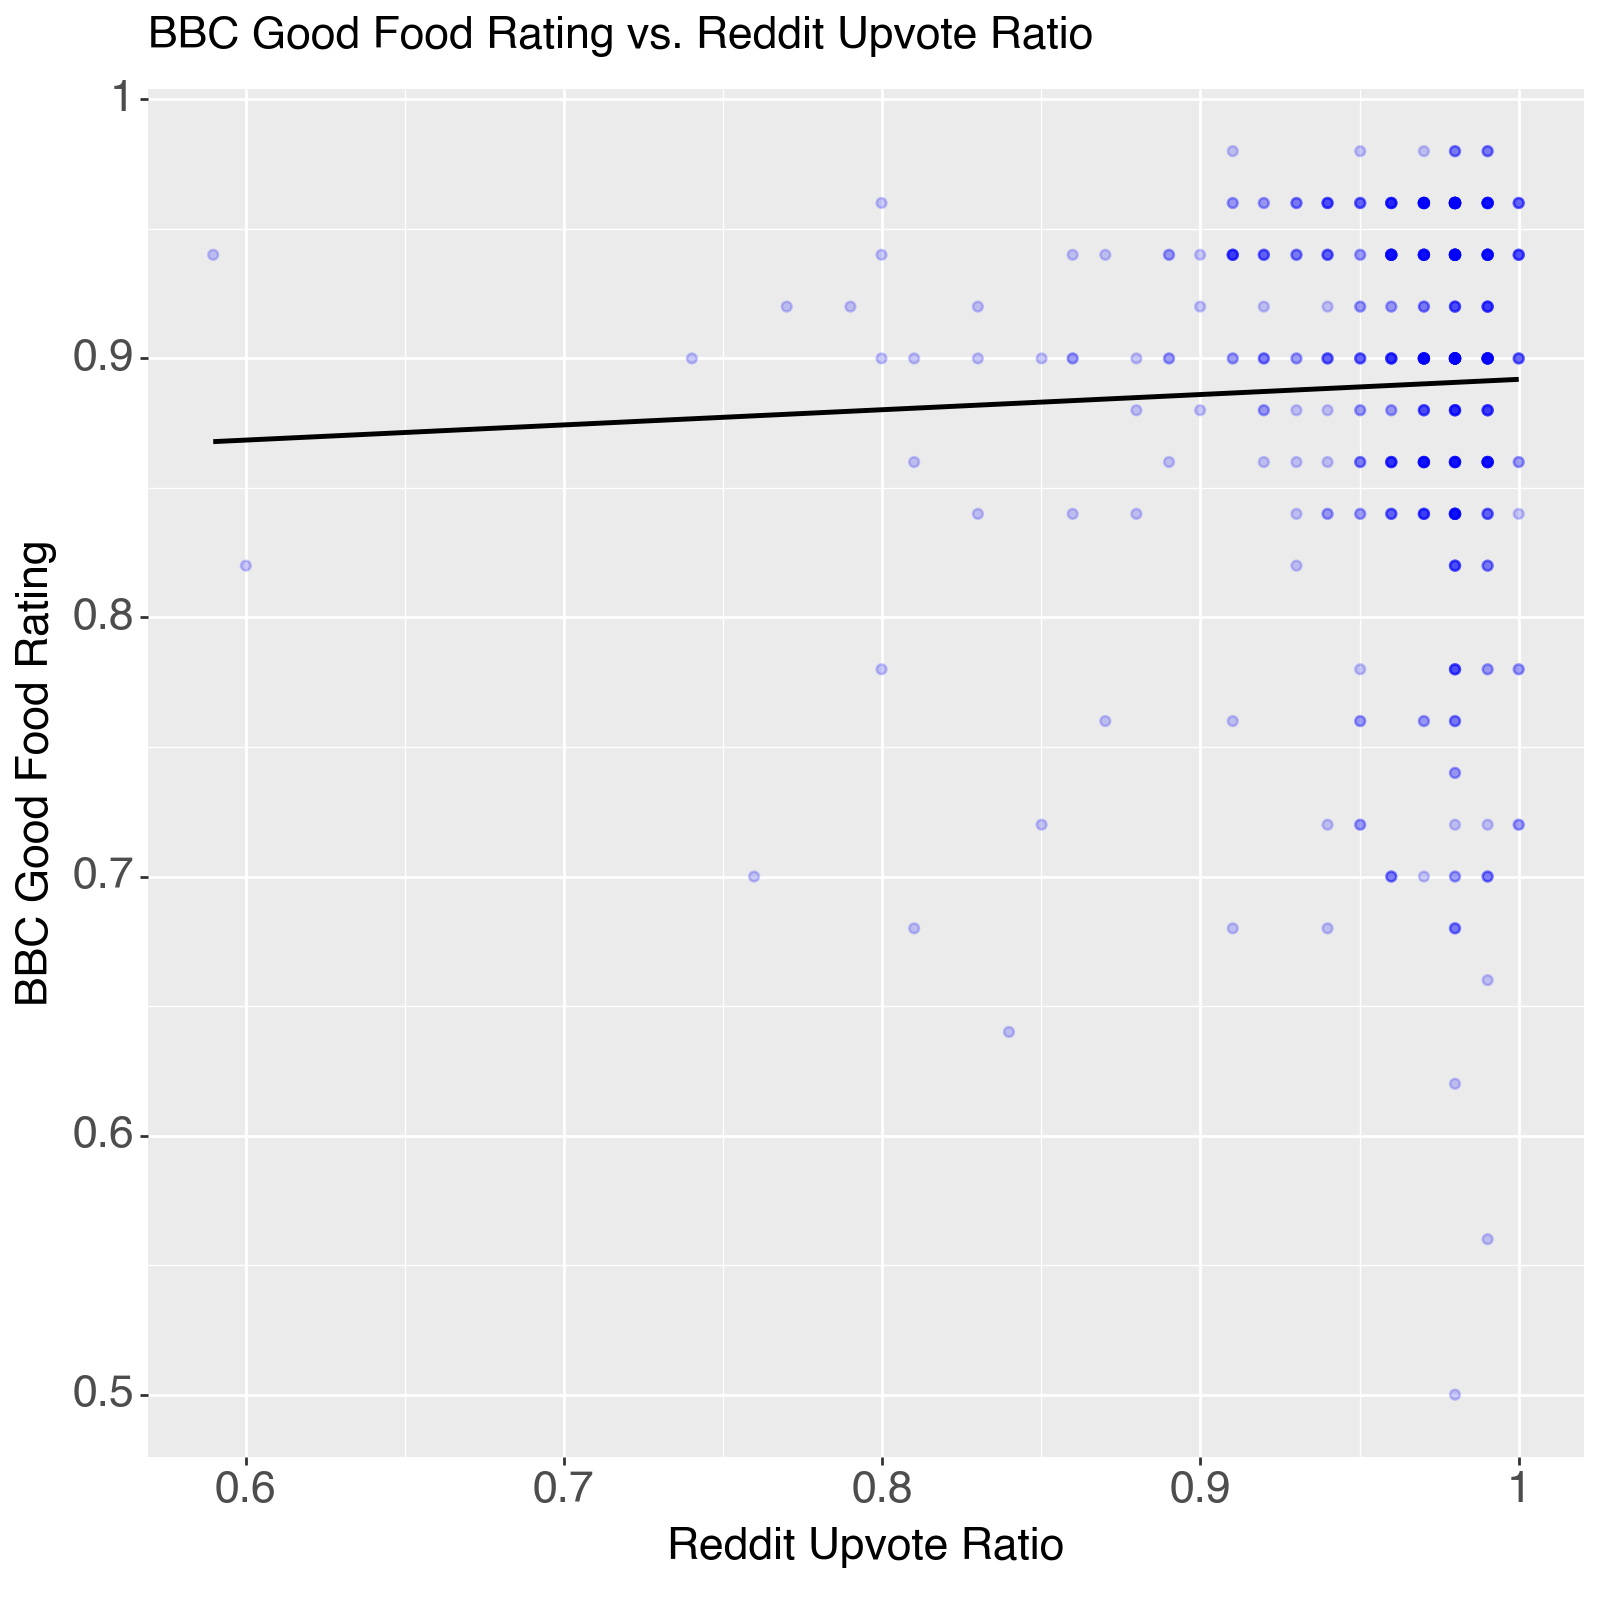

<Figure Size: (800 x 800)>

In [31]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, xlim, ylim
# create a scatter plot of upvote ratio vs. bbc rating
plot = (
    ggplot(df_for_analysis, aes(x='upvote_ratio', y='bbcgf_ratings')) +
    geom_point(alpha=0.2, color='blue') +
    geom_smooth(method='lm', se=False) +
    labs(
        title='BBC Good Food Rating vs. Reddit Upvote Ratio',
        x='Reddit Upvote Ratio',
        y='BBC Good Food Rating'
    ) +
    theme(
        text=element_text(size=16),
        figure_size=(8, 8)
    )
)

plot 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 21 rows containing missing values.


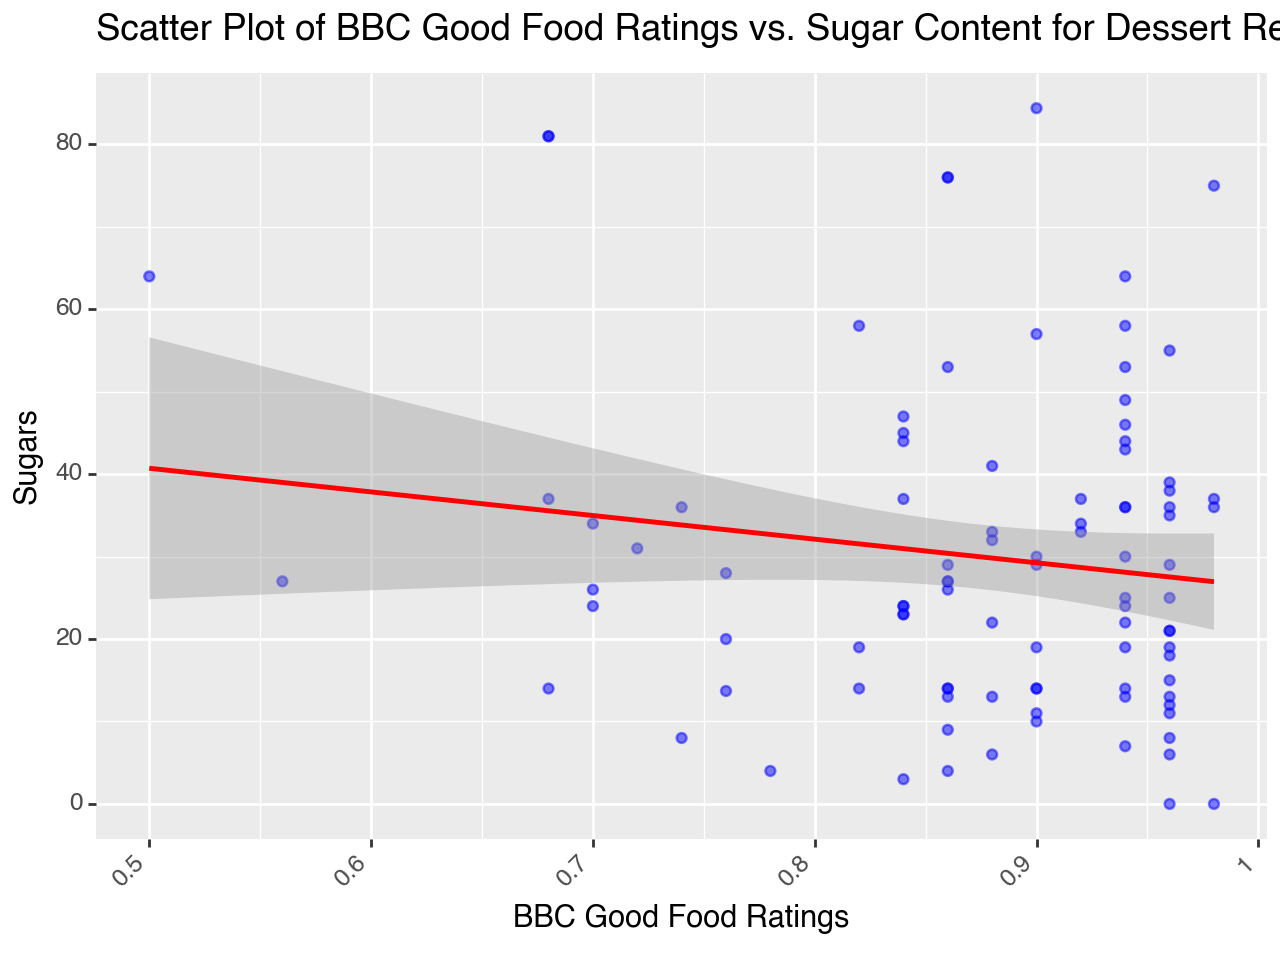

In [23]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, xlim, ylim

plot = (
    ggplot(df_desserts, aes(x='bbcgf_ratings', y='sugars')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of BBC Good Food Ratings vs. Sugar Content for Dessert Recipes', x='BBC Good Food Ratings', y='Sugars') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot)

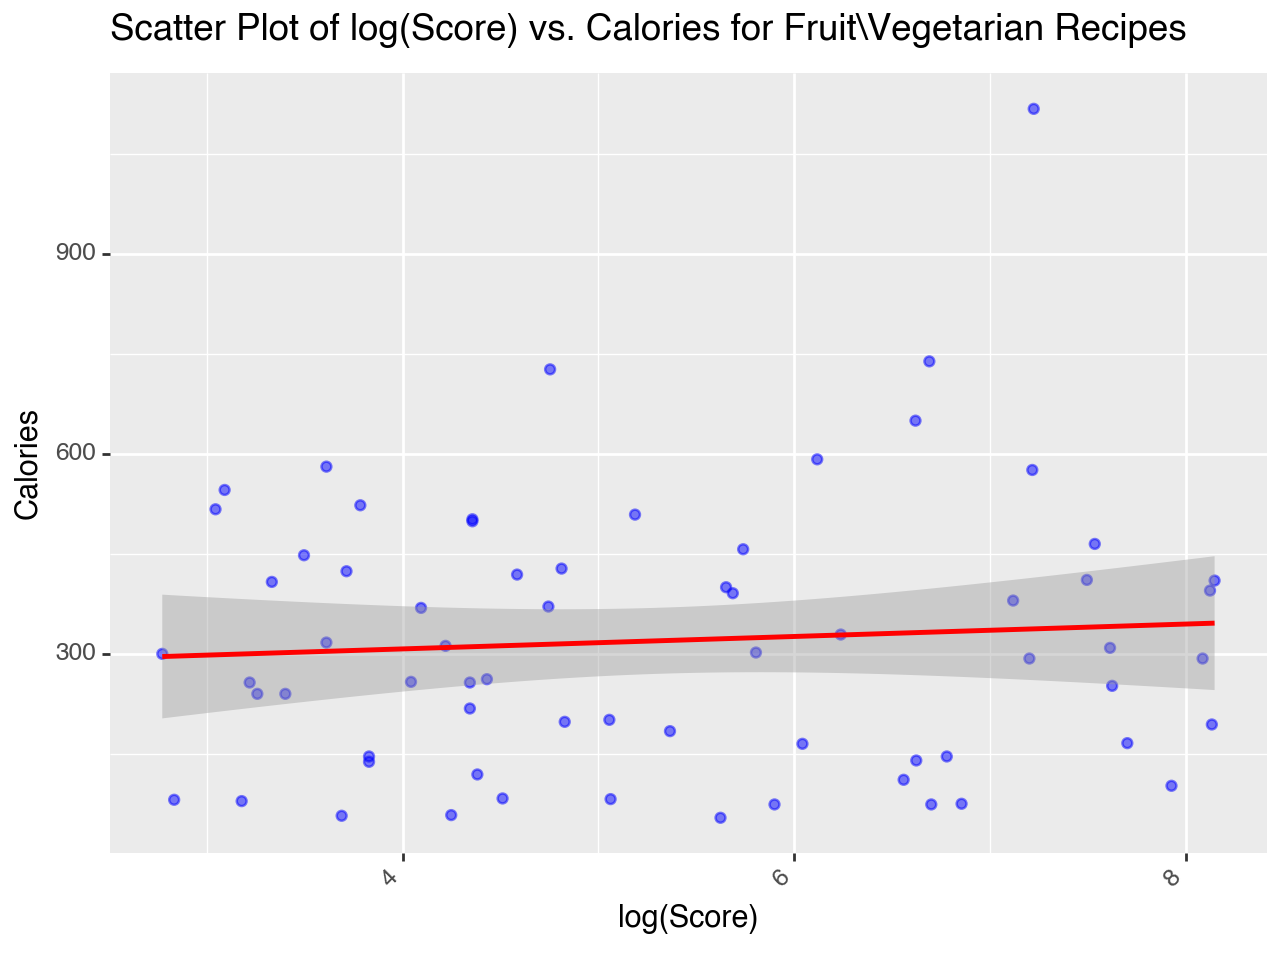

In [89]:
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme, element_text

plot = (
    ggplot(df_fruitveg, aes(x=np.log(df_fruitveg['score']), y='calories')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of log(Score) vs. Calories for Fruit\Vegetarian Recipes', x='log(Score)', y='Calories') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot)


/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 22 rows containing missing values.


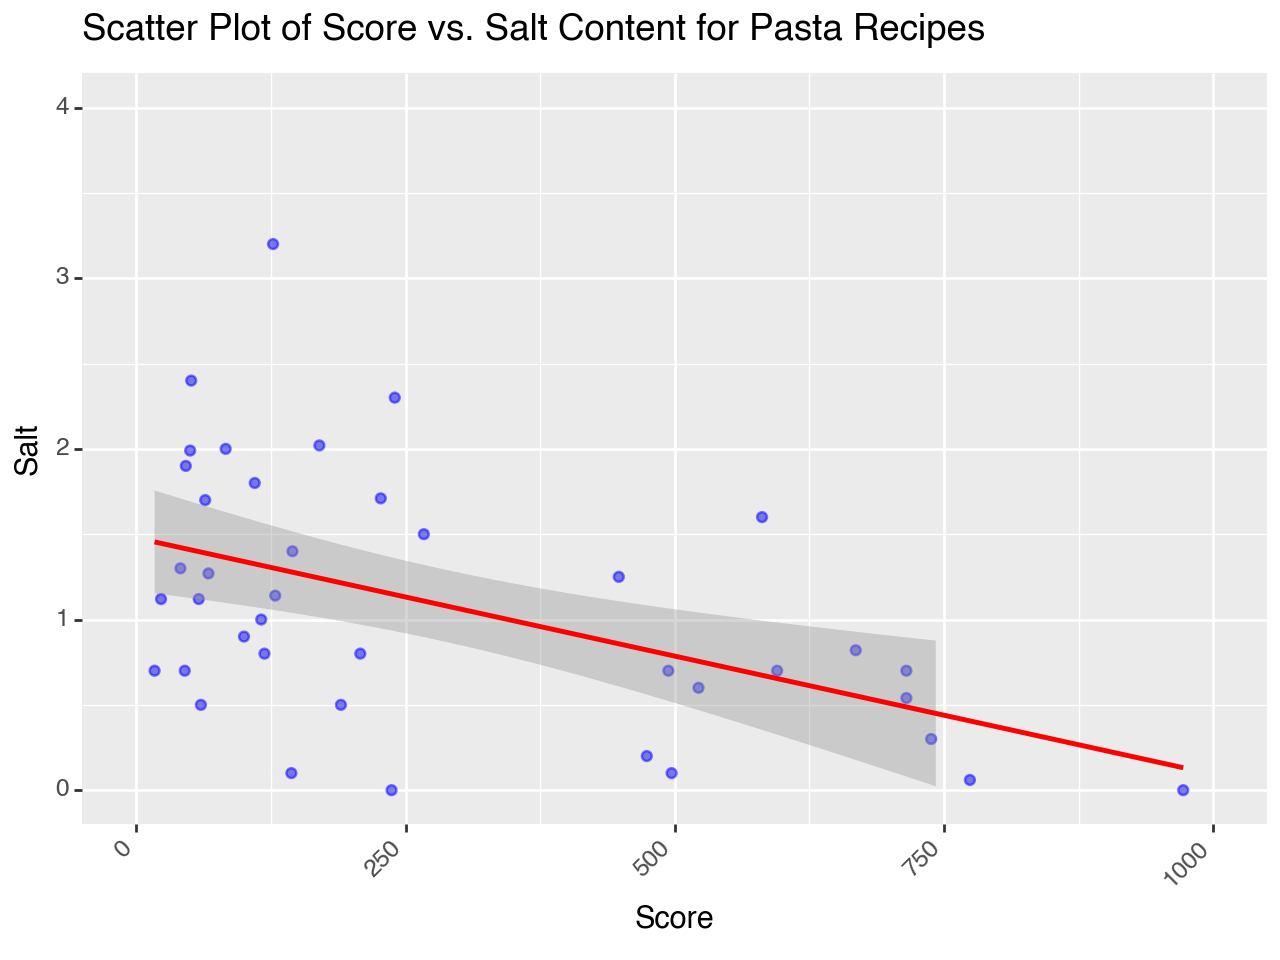

In [95]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, xlim, ylim

plot = (
    ggplot(df_pasta, aes(x='score', y='salt')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Score vs. Salt Content for Pasta Recipes', x='Score', y='Salt') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + xlim(0, 1000)
    + ylim(0, 4)
)

print(plot)